In [1]:
%load_ext autoreload
%autoreload 2

# Maximally excitatory stimuli from trained models

This notebook illustrates how to compute the stimuli that maximally excite a specific neuron.

**Select GPU runtime**

To run the notebook on a GPU select Menu -> Runtime -> Change runtime type -> GPU.

In [2]:
# @markdown **Check access to GPU**

try:
    import google.colab

    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    import torch

    try:
        cuda_name = torch.cuda.get_device_name()
        print(f"Name of the assigned GPU / CUDA device: {cuda_name}")
    except RuntimeError:
        import warnings

        warnings.warn(
            "You have not selected Runtime Type: 'GPU' or Google could not assign you one. Please revisit the settings as described above or proceed on CPU (slow)."
        )

**Install Flyvis**

The notebook requires installing our package `flyvis`. You may need to restart your session after running the code block below with Menu -> Runtime -> Restart session. Then, imports from `flyvis` should succeed without issue.

In [3]:
if IN_COLAB:
    #@markdown **Install Flyvis**
    %%capture
    !git clone https://github.com/flyvis/flyvis-dev.git
    %cd /content/flyvis-dev
    !pip install -e .

In [4]:
# basic imports
import matplotlib.pyplot as plt
import numpy as np
import torch

plt.rcParams['figure.dpi'] = 200

# Create optimal stimuli

In [5]:
from flyvision import NetworkView, results_dir
from flyvision.datasets.sintel import AugmentedSintelLum

In [6]:
dt = 1 / 200  # can be changed for other temporal resolutions
dataset = AugmentedSintelLum(tasks=["lum"], dt=dt, temporal_split=True)

In [7]:
from flyvision.analysis.optimal_stimuli import NaturalisticOptimalStimuli, ArtificialOptimalStimuli, plot_stim_response

In [8]:
network_view = NetworkView(results_dir / "flow/0000/000")

[2024-08-08 02:24:20] [logging_utils.py:8] Loading paper result from stored checkpoint and validation subdir...


In [11]:
art = ArtificialOptimalStimuli(network_view)

[2024-08-08 02:00:09] [network.py:238] Initialized network with NumberOfParams(free=734, fixed=2959) parameters.
[2024-08-08 02:00:09] [chkpt_utils.py:68] Recovered network state.


In [13]:
art_opt_stim, responses, losses = art.artificial_optimal_stimuli("T4c")

StimResponsePlot(stim=array([[0.49998692, 0.4999942 , 0.5000177 , ..., 0.5000571 , 0.5001044 ,
        0.5002188 ],
       [0.49998823, 0.49998075, 0.49998707, ..., 0.5000464 , 0.50013417,
        0.5001666 ],
       [0.49999574, 0.49999365, 0.49998754, ..., 0.5000335 , 0.5001306 ,
        0.50015604],
       ...,
       [0.49999657, 0.49999052, 0.5000011 , ..., 0.49999768, 0.49999878,
        0.49997258],
       [0.49999478, 0.5000021 , 0.49999094, ..., 0.5000002 , 0.5000003 ,
        0.49999446],
       [0.5000005 , 0.50000036, 0.49999553, ..., 0.5000006 , 0.4999865 ,
        0.50001687]], dtype=float32), response=array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [2.0503998e-05, 1.6927719e-05, 1.5854836e-05, ..., 5.9142709e-05,
        5.9857965e-05, 4.8138201e-05],
       [3.9398670e-05, 2.7656555e-05, 1.6927719e-05, ..., 1.3000518e-04,
        1.4459342e-04, 1.2645125e-04],
       ...,
       [1.6540289e-04, 1.813

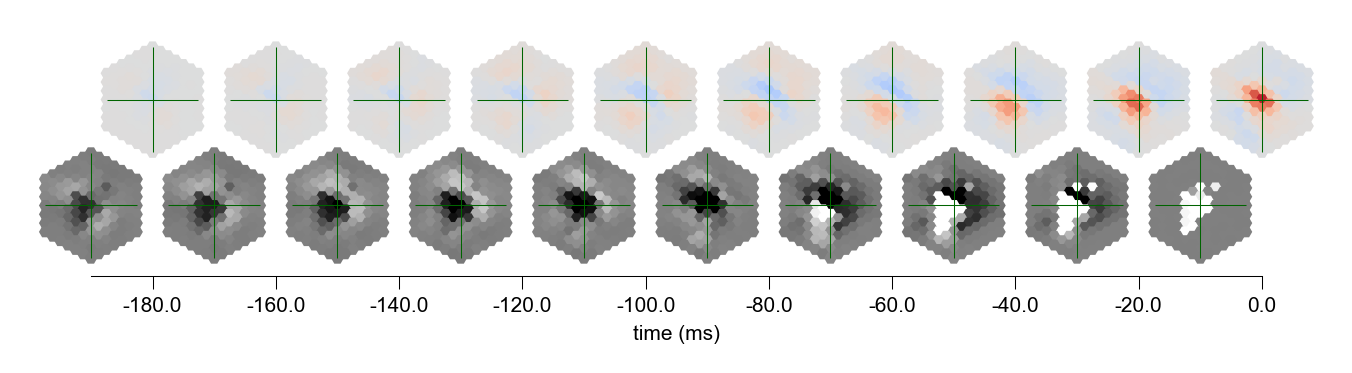

In [14]:
plot_stim_response(art_opt_stim, responses, 1/100, *network_view.get_uv("T4c"), figsize=[5, 1.6], ylabel=None, label_peak_response=False)

In [9]:
natural = NaturalisticOptimalStimuli(network_view)

[2024-08-08 02:24:30] [network.py:238] Initialized network with NumberOfParams(free=734, fixed=2959) parameters.
[2024-08-08 02:24:30] [chkpt_utils.py:68] Recovered network state.


In [10]:
natural.compute_responses_to_naturalistic_stimuli()

[2024-08-08 02:24:35] [network.py:728] Computing 2268 stimulus responses.


Batch:   0%|          | 0/567 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [15]:
natural.naturalistic_stimuli[0]

{'lum': tensor([[[0.4548, 0.4299, 0.1217,  ..., 0.2772, 0.2760, 0.2801]],
 
         [[0.4548, 0.4299, 0.1217,  ..., 0.2772, 0.2760, 0.2801]],
 
         [[0.4548, 0.4299, 0.1217,  ..., 0.2772, 0.2760, 0.2801]],
 
         ...,
 
         [[0.1646, 0.2921, 0.3990,  ..., 0.2405, 0.2374, 0.2343]],
 
         [[0.1646, 0.2921, 0.3990,  ..., 0.2405, 0.2374, 0.2343]],
 
         [[0.1646, 0.2921, 0.3990,  ..., 0.2405, 0.2374, 0.2343]]],
        device='cuda:0')}

In [17]:
network = natural.network

In [22]:
def make_hashable(obj):
    if isinstance(obj, (int, float, str)):
        return obj
    elif isinstance(obj, tuple):
        return tuple(make_hashable(o) for o in obj)
    elif isinstance(obj, set):
        return frozenset(obj)
    # convert lists and arrays to tuples
    # because must be immutable
    elif isinstance(obj, (list, np.ndarray)):
        return tuple(obj)
    elif isinstance(obj, dict):
        return tuple((make_hashable(k), make_hashable(v)) for k, v in obj.items())
    return (obj,)

cache_key = make_hashable((1/100, 4, 0.0, 2.0, [0, 1, 2, 3], dict(a=1, b=2), np.array([1, 2, 3]), set([1, 2, 3])))

In [24]:
{cache_key: 1}

{(0.01,
  4,
  0.0,
  2.0,
  (0, 1, 2, 3),
  (('a', 1), ('b', 2)),
  (1, 2, 3),
  frozenset({1, 2, 3})): 1}

In [13]:
    if isinstance(obj, list):
        return tuple(obj)
    elif isinstance(obj, np.ndarray):
        return tuple(obj.tolist())
    elif isinstance(obj, dict):
        return tuple((k, make_hashable(v)) for k, v in obj.items())

((0.01, 4, 0.0, 2.0, [0, 1, 2, 3]),)

In [37]:
nat_opt_stim, responses = natural.naturalistic_optimal_stimuli("T4c", 
                                                               indices=[0, 1, 2, 3])

StimResponsePlot(stim=array([[0.19331703, 0.184685  , 0.20034815, ..., 0.10906155, 0.10813335,
        0.10507032],
       [0.19331703, 0.184685  , 0.20034815, ..., 0.10906155, 0.10813335,
        0.10507032],
       [0.19331703, 0.184685  , 0.20034815, ..., 0.10906155, 0.10813335,
        0.10507032],
       ...,
       [0.6880377 , 0.34289366, 0.21659131, ..., 0.11145148, 0.11493225,
        0.11026819],
       [0.6880377 , 0.34289366, 0.21659131, ..., 0.11145148, 0.11493225,
        0.11026819],
       [0.6880377 , 0.34289366, 0.21659131, ..., 0.11145148, 0.11493225,
        0.11026819]], dtype=float32), response=array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 2.0563602e-05,  1.6927719e-05,  1.5974045e-05, ...,
         5.9053302e-05,  5.9917569e-05,  4.8078597e-05],
       [-7.9048634e-02, -9.6568406e-02, -9.9687219e-02, ...,
        -9.2345484e-02, -9.2571385e-02, -8.2248844e-02],
       ...,
       [-8

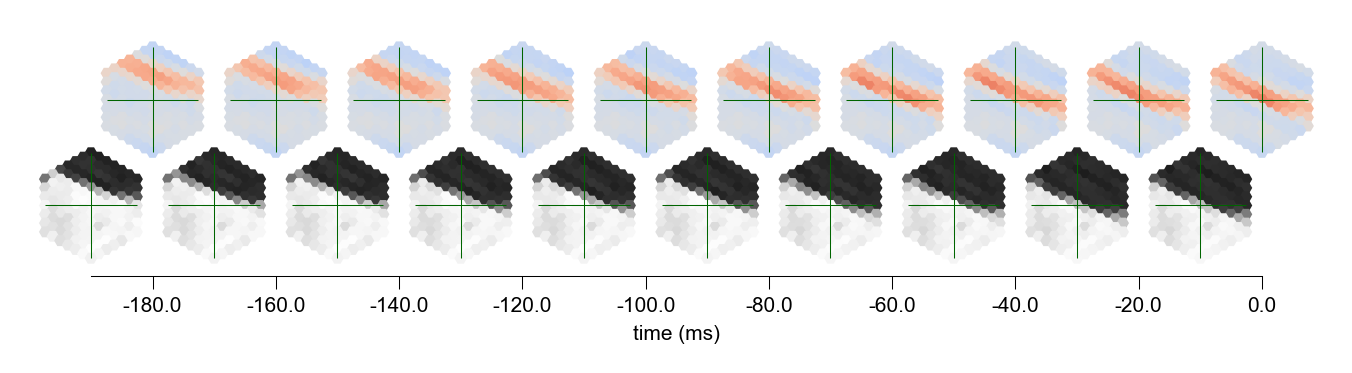

In [38]:
plot_stim_response(nat_opt_stim, responses, 1/100, *network_view.get_uv("T4c"), figsize=[5, 1.6], ylabel=None, label_peak_response=False)

In [42]:
reg_opt_stim = natural.regularized_naturalistic_optimal_stimuli("T4c", 
                                                               indices=[0, 1, 2, 3])

[2024-08-08 02:51:54] [network.py:728] Computing 4 stimulus responses.


Batch:   0%|          | 0/1 [00:00<?, ?it/s]

In [45]:
reg_opt_stim.stimulus

NatOptimalStimuli(stimulus=tensor([[[[0.1933, 0.1847, 0.2003,  ..., 0.1091, 0.1081, 0.1051]],

         [[0.1933, 0.1847, 0.2003,  ..., 0.1091, 0.1081, 0.1051]],

         [[0.1933, 0.1847, 0.2003,  ..., 0.1091, 0.1081, 0.1051]],

         ...,

         [[0.6880, 0.3429, 0.2166,  ..., 0.1115, 0.1149, 0.1103]],

         [[0.6880, 0.3429, 0.2166,  ..., 0.1115, 0.1149, 0.1103]],

         [[0.6880, 0.3429, 0.2166,  ..., 0.1115, 0.1149, 0.1103]]]],
       device='cuda:0'), response=tensor([[[[ 0.9567,  1.0810,  1.1139,  ...,  0.0847,  0.0968,  0.0853]],

         [[ 0.9567,  1.0810,  1.1139,  ...,  0.0848,  0.0969,  0.0854]],

         [[ 0.8777,  0.9844,  1.0142,  ..., -0.0077,  0.0042,  0.0031]],

         ...,

         [[ 0.8667,  0.9129,  0.8973,  ...,  0.4142,  0.4227,  0.4694]],

         [[ 0.8372,  0.8695,  0.8620,  ...,  0.4140,  0.4224,  0.4690]],

         [[ 0.8001,  0.8187,  0.8209,  ...,  0.4137,  0.4221,  0.4685]]]]))

StimResponsePlot(stim=array([[0.4979775 , 0.49796322, 0.49807206, ..., 0.5015317 , 0.50159556,
        0.50180334],
       [0.49797747, 0.4979632 , 0.49807206, ..., 0.5015318 , 0.50159556,
        0.5018032 ],
       [0.49797744, 0.49796316, 0.49807203, ..., 0.5015318 , 0.50159556,
        0.5018031 ],
       ...,
       [0.49973226, 0.4991906 , 0.49855658, ..., 0.5013696 , 0.5011321 ,
        0.5014503 ],
       [0.49973226, 0.4991906 , 0.49855658, ..., 0.5013696 , 0.5011321 ,
        0.5014503 ],
       [0.49973226, 0.4991906 , 0.49855658, ..., 0.5013696 , 0.5011321 ,
        0.5014503 ]], dtype=float32), response=array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 2.0563602e-05,  1.6927719e-05,  1.5974045e-05, ...,
         5.9053302e-05,  5.9768558e-05,  4.8048794e-05],
       [-4.3737888e-04, -5.4335594e-04, -5.3703785e-04, ...,
         4.7012419e-04,  4.8734993e-04,  4.4802576e-04],
       ...,
       [-7

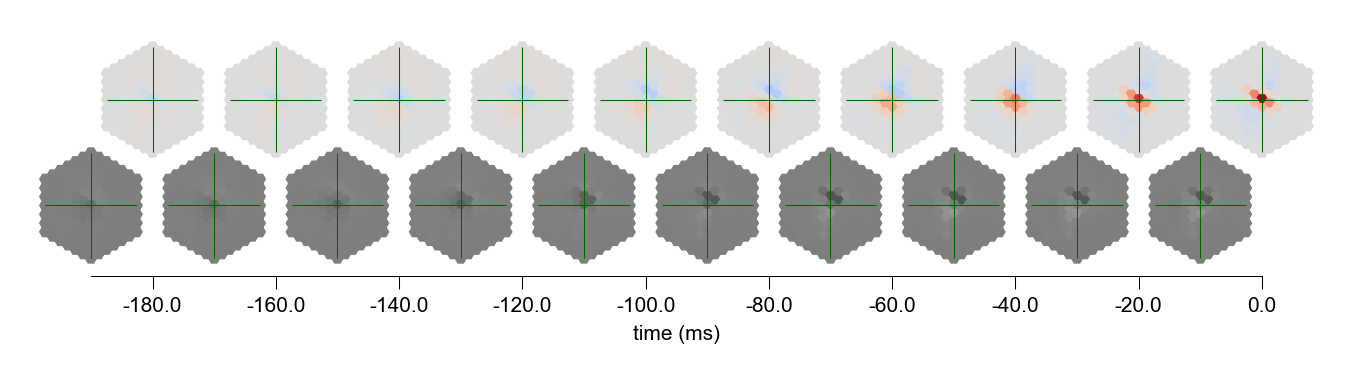

In [46]:
plot_stim_response(reg_opt_stim.regularized_stimulus, reg_opt_stim.response, 1/100, *network_view.get_uv("T4c"), figsize=[5, 1.6], ylabel=None, label_peak_response=False)